# Mean Reversion and Momentum Signal Generation
This notebook demonstrates how to:
- Download historical price data
- Build **basic** mean reversion and momentum signals
- Evaluate them against a benchmark (SPY)
- Then **improve** the signals using z‑score thresholds and moving‑average + volatility filters.

## 1. Imports and Data Download

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

plt.rcParams['figure.figsize'] = (12, 5)
%matplotlib inline

# Download daily close prices for a small universe
tickers = ['SPY', 'QQQ', 'IWM']
data = yf.download(tickers, start='2015-01-01')['Close']
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


Ticker,IWM,QQQ,SPY
Date,,,
2015-01-02,103.315102,94.906563,171.093674
2015-01-05,101.933899,93.514389,168.003769
2015-01-06,100.170425,92.260529,166.421356
2015-01-07,101.403984,93.449837,168.495132
2015-01-08,103.124008,95.238457,171.485153


## 2. Benchmark: SPY Buy‑and‑Hold

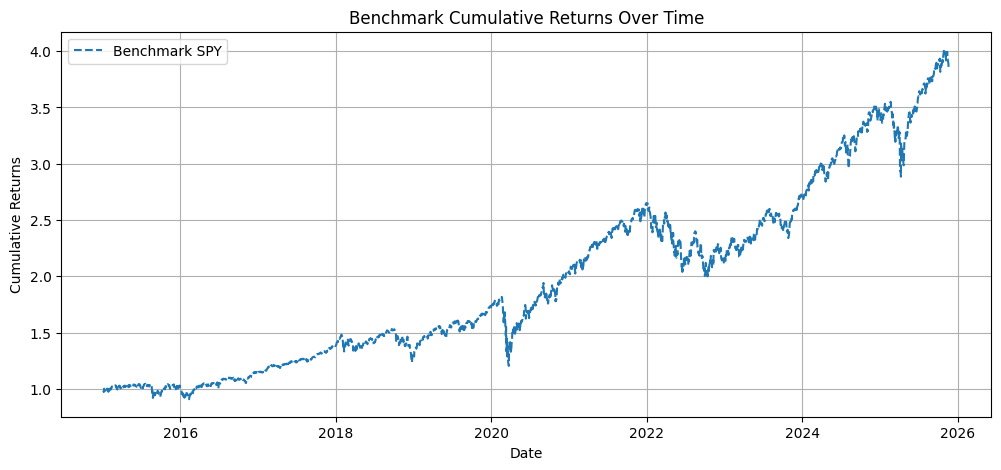

In [2]:
# Compute daily returns and cumulative benchmark performance
returns = data['SPY'].pct_change()
cum_bench = (1 + returns).cumprod()

plt.plot(cum_bench, label='Benchmark SPY', linestyle='--')
plt.title('Benchmark Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

## 3. Basic Signals
In this first pass we intentionally use **very simple** signal definitions:
- Mean reversion: take the *opposite* of a 5‑day return z‑score (`-sign(z)`).
- Momentum: take the sign of the 20‑day price change.

This gives us a baseline to improve on later.

In [3]:
# === Basic Mean Reversion Signal ===
# 5‑day z‑score of daily returns
z = (returns - returns.rolling(5).mean()) / returns.rolling(5).std()

# Basic mean reversion: always take the opposite side of extremes
signal_mr_basic = -np.sign(z)
signal_mr_basic = pd.Series(signal_mr_basic, index=returns.index)

# Apply signal with 1‑day lag to avoid lookahead bias
ret_mr_basic = signal_mr_basic.shift(1) * returns
cum_mr_basic = (1 + ret_mr_basic).cumprod()

# === Basic Momentum Signal ===
mom_raw = data['SPY'].pct_change(20)
signal_mom_basic = np.sign(mom_raw)
signal_mom_basic = pd.Series(signal_mom_basic, index=returns.index)

ret_mom_basic = signal_mom_basic.shift(1) * returns
cum_mom_basic = (1 + ret_mom_basic).cumprod()

### 3.1 Performance of Basic Signals

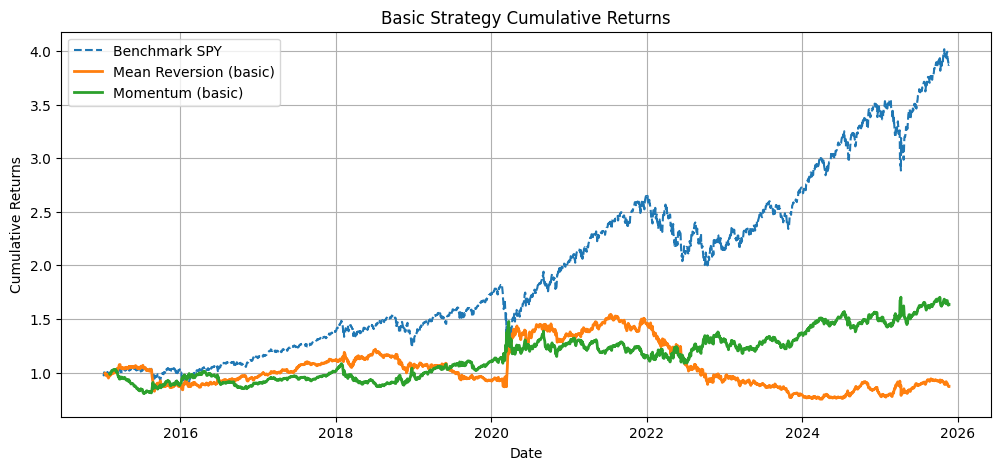

Sharpe (Mean Reversion, basic): 0.02
Sharpe (Momentum, basic):       0.34
Sharpe (Benchmark SPY):         0.79


In [4]:
plt.plot(cum_bench, label='Benchmark SPY', linestyle='--')
plt.plot(cum_mr_basic, label='Mean Reversion (basic)', linewidth=2)
plt.plot(cum_mom_basic, label='Momentum (basic)', linewidth=2)
plt.title('Basic Strategy Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

def sharpe(series):
    return np.sqrt(252) * series.mean() / series.std()

print('Sharpe (Mean Reversion, basic):', round(sharpe(ret_mr_basic.dropna()), 2))
print('Sharpe (Momentum, basic):      ', round(sharpe(ret_mom_basic.dropna()), 2))
print('Sharpe (Benchmark SPY):        ', round(sharpe(returns.dropna()), 2))

## 4. Improved Signals
Now we refine both signals:

**Improved mean reversion**
- Only trade when the z‑score is *extreme* (>|1|), otherwise stay flat.

**Improved momentum**
- Use a 50/200‑day moving‑average crossover to define the trend.
- Add a volatility filter so we only trade when 20‑day volatility is below its 80th percentile.


In [5]:
# === Improved Mean Reversion: z‑score thresholds ===
signal_mr_imp = np.where(z > 1, -1,
                   np.where(z < -1, 1, 0))
signal_mr_imp = pd.Series(signal_mr_imp, index=returns.index)

ret_mr_imp = signal_mr_imp.shift(1) * returns
cum_mr_imp = (1 + ret_mr_imp).cumprod()

# === Improved Momentum: MA crossover + volatility filter ===
short_ma = data['SPY'].rolling(50).mean()
long_ma  = data['SPY'].rolling(200).mean()
vol = returns.rolling(20).std()

trend_up = short_ma > long_ma
low_vol  = vol < vol.quantile(0.8)
signal_mom_imp = np.where(trend_up & low_vol, 1, 0)
signal_mom_imp = pd.Series(signal_mom_imp, index=returns.index)

ret_mom_imp = signal_mom_imp.shift(1) * returns
cum_mom_imp = (1 + ret_mom_imp).cumprod()

### 4.1 Performance of Improved Signals

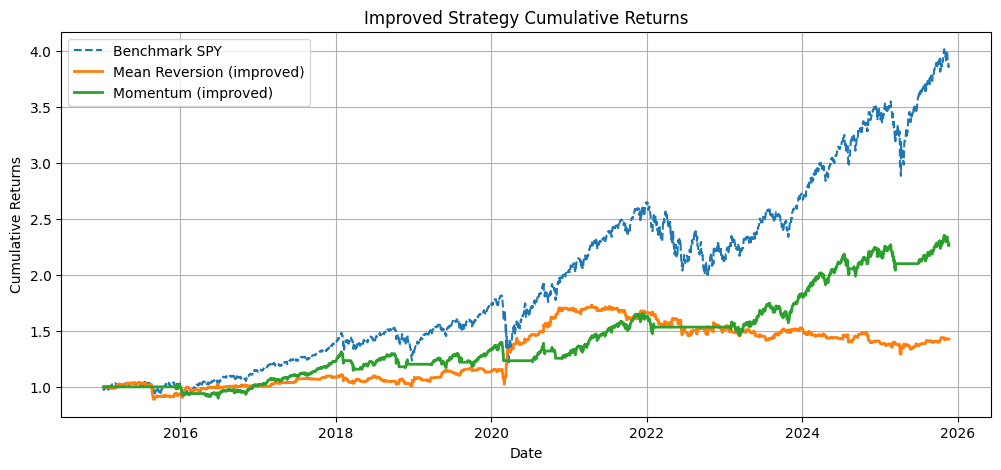

Sharpe (Mean Reversion, improved): 0.37
Sharpe (Momentum, improved):       0.79
Sharpe (Benchmark SPY):            0.79


In [6]:
plt.plot(cum_bench, label='Benchmark SPY', linestyle='--')
plt.plot(cum_mr_imp, label='Mean Reversion (improved)', linewidth=2)
plt.plot(cum_mom_imp, label='Momentum (improved)', linewidth=2)
plt.title('Improved Strategy Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

print('Sharpe (Mean Reversion, improved):', round(sharpe(ret_mr_imp.dropna()), 2))
print('Sharpe (Momentum, improved):      ', round(sharpe(ret_mom_imp.dropna()), 2))
print('Sharpe (Benchmark SPY):           ', round(sharpe(returns.dropna()), 2))